In [14]:
import gym
import numpy as np
import random
import time
from matplotlib import pyplot as plt

from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda', index=0)

In [15]:
random.seed(time.time())
# Create the lunar lander environment
env = gym.make("LunarLander-v2")
env.reset(seed=int(time.time()))

# Define global variables
epsilonDecayFactor = 0.995
learningRate = 0.0005
gamma = 0.99
batchSize = 64


## Neural Netwrok

In [16]:
# Create a neural network for q function approximation
class NeuralNetwork(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(NeuralNetwork, self).__init__()
        # Use a three layer network layer1 (8, 128), layer2 (128, 128), layer3 (128, 4)
        self.netwrokModel = nn.Sequential(
            nn.Linear(inputSize, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, outputSize),
        )

    def forward(self, x):
        output = self.netwrokModel(x)
        return output

## Deep Q Learning

In [17]:
# Class to implement the DQN process
class DQN():
    # Initialize class paramters
    def __init__(self, epsilonMin_ = 0.03, epsilonDecayFactor_ = epsilonDecayFactor, learningRate_ = learningRate):
        self.inputSize = env.observation_space.shape[0]
        self.outputSize = env.action_space.n
        self.epsilon = 1.0
        self.epsilonMin = epsilonMin_
        self.epsilonDecayFactor = epsilonDecayFactor_
        self.learningRate = learningRate_
        self.gamma = gamma
        # self.totalEpisodes = 3000
        self.syncTargetNetwork = 1000 # When to copy current network paramters to target netowrk
        self.stepCount = 0
        
        # Create the two neural network instances
        self.currentNetwork = NeuralNetwork(inputSize = self.inputSize, outputSize = self.outputSize).to(device)
        self.targetNetwork = NeuralNetwork(inputSize = self.inputSize, outputSize = self.outputSize).to(device)
        # Optimizer and loss criterion for the networks
        self.optimizer = optim.Adam(self.currentNetwork.parameters(), lr=learningRate)
        self.criterion = nn.MSELoss()  # using mean square error as loss function
        
        # Initialize the replay buffer
        self.replayBuffer = deque(maxlen=100000)

    # Decay eploration (epsilon) by the decay factor till it hits min value    
    def decayEpsilon(self):
        self.epsilon = max(self.epsilon*self.epsilonDecayFactor, self.epsilonMin)
        return self.epsilon
    
    # Choose an action for a given state based on epsilon greedy policy
    def chooseAction(self, state, useRandomPolicy = False):
        action = 0
        # Explorative choice
        if useRandomPolicy or np.random.uniform(0, 1) < self.epsilon:
            action  = random.randrange(0, self.outputSize)
        # Exploitative choice
        else:
            self.currentNetwork.eval()  # Switch network to evaluation mode
            with torch.no_grad():
                action = self.currentNetwork(torch.tensor(state).to(device)).argmax().item()
            self.currentNetwork.train() # Switch network back to training mode
        return action
    
    # Get best actyion from trained policy
    def getBestAction(self, state):
        return self.currentNetwork(torch.tensor(state).to(device)).argmax().item()
    
    # Implemnt the q learning function when experience replay is enabled
    def learnWithReplay(self):
        # Check if sufficient samples are present in replay buffer
        if len(self.replayBuffer) > batchSize:
            # sample a mini batch from the buffer
            sampleBatch = random.sample(self.replayBuffer, batchSize)
            # convert the sample values to tensors to pass to the network
            stateList = torch.tensor(np.array([sample[0] for sample in sampleBatch])).float().to(device)
            actions = torch.tensor([[sample[1]] for sample in sampleBatch]).to(device)
            nextStateList = torch.tensor(np.array([sample[2] for sample in sampleBatch])).float().to(device)
            rewards = torch.tensor([[sample[3]] for sample in sampleBatch]).float().to(device)
            terminalList = torch.tensor([[1 if sample[4] else 0] for sample in sampleBatch]).to(device)
            # Calculate the target Q values
            QtMax = self.targetNetwork(nextStateList).detach().max(1)[0].unsqueeze(1)
            targets = rewards + gamma*(QtMax)*(1 - terminalList)
            # Compute current Q value approximations
            currentOutput = self.currentNetwork(stateList).gather(1, actions)
            # Train the network
            loss = self.criterion(currentOutput, targets)
            self.optimizer.zero_grad()   # zero the gradient buffers
            loss.backward()
            self.optimizer.step()
     
    # Implemnt the Q learning function with experience replay disabled
    def learnWithoutReplay(self, sample):
        # Directly run the sample through the Q learning process
        state, action, nextState, reward, terminal = sample
        # Convert sample values to tensors
        state = torch.tensor(state).to(device)
        nextState = torch.tensor(nextState).to(device)
        reward =  torch.tensor(reward).to(device)
        qt = self.targetNetwork(nextState).detach().max()
        # print(qt, qt.size())
        target = (reward + gamma*(qt)*(1-terminal)).float()
        # print(target.size())
        current = self.currentNetwork(state)[action].float()
        # print(current.size())
        # Train the network
        loss = self.criterion(current, target)
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        self.optimizer.step()
        
    # Run the learning algorithm for a given step
    def run(self, sample, useReplay = True):
        # Check if replay is enabled and choose the corresponding learning option
        if useReplay:
            # Add sample to buffer and learn
            self.replayBuffer.append(sample)
            self.learnWithReplay()
        else:
            self.learnWithoutReplay(sample)
        # Increment overall step count   
        self.stepCount += 1
        # Update the target network
        self.updateTargetNetwork()
    
    # Update the target network every N number of steps (given by self.syncTargetNetwork)
    def updateTargetNetwork(self):
        if self.stepCount % self.syncTargetNetwork == 0:
            self.targetNetwork.load_state_dict(self.currentNetwork.state_dict())
            
    # Save the network to a file
    def saveNetwork(self):
        torch.save(self.currentNetwork.state_dict(), './model.torch')
    
    # Load network weights from fiel
    def loadNetwork(self, fileName="model"):
        modelFromFile = torch.load('./'+fileName+'.torch')
        print(modelFromFile, type(modelFromFile))
        self.currentNetwork.load_state_dict(modelFromFile)
        

In [18]:
# Runs the main training loop
def trainAgent(agent, totalEpisodes = 2000, steps = 1000, useReplay = True, targetReward = 200, useRandomPolicy = False):
    rewardList = []
    meanRewards = []
    # Iterate over episodes
    for episode in range(totalEpisodes):
        state = env.reset()
        totalReward = 0
        # Go through the steps for ea100000pisode
        for step in range(steps):
            # env.render()
            action = agent.chooseAction(state, useRandomPolicy)
            nextState, reward, terminal, _ = env.step(action)
            sample = (state, action, nextState, reward, terminal)
            # Run an iteration of the learning algorithm for the agent
            agent.run(sample, useReplay)
            # Update cumulative reward and state
            totalReward += reward
            state = nextState
            # Stop on terminal state
            if terminal: break
        # Decay epsilon every episode
        agent.decayEpsilon()
        rewardList.append(totalReward)
        mean = np.mean(rewardList[-100:])
        if episode%100 == 0: print("Episode : {}\t epsilon : {:.3f}\t Reward : {:.2f}".format(episode, agent.epsilon, mean))
        meanRewards.append(mean)
        # Step when mean reward exceeds 220
        if mean > targetReward and len(meanRewards)>100:
            print("Training complete in", episode, "episodes, with mean reward (last 100): ", mean)
            break
    return rewardList, meanRewards

## Frozen Targets with Experience Replay

In [19]:
# Create instance of the DQN agent
landerAgent = DQN()            
rewards , avgRewards_1  = trainAgent(landerAgent, targetReward=220)

Episode : 0	 epsilon : 0.995	 Reward : -226.65
Episode : 100	 epsilon : 0.603	 Reward : -135.29
Episode : 200	 epsilon : 0.365	 Reward : -61.89
Episode : 300	 epsilon : 0.221	 Reward : 39.56
Episode : 400	 epsilon : 0.134	 Reward : 163.27
Training complete in 466 episodes, with mean reward (last 100):  221.1670513476556


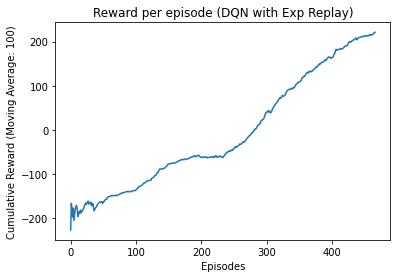

In [20]:
plt.figure()
plt.plot(range(len(avgRewards_1)), avgRewards_1)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward (Moving Average: 100)")
plt.title("Reward per episode (DQN with Exp Replay)")
plt.show()
landerAgent.saveNetwork()

## No Experience Replay (Frozen Targets)

In [115]:
# Case with no replay buffer
landerAgentNoReplay = DQN(epsilonDecayFactor_=0.9985, learningRate_ = 0.0001)
rewards, avgRewards = trainAgent(landerAgentNoReplay, totalEpisodes = 8000, useReplay=False)


Episode : 0	 epsilon : 0.999	 Reward : -329.87
Episode : 100	 epsilon : 0.859	 Reward : -182.58
Episode : 200	 epsilon : 0.740	 Reward : -186.14
Episode : 300	 epsilon : 0.636	 Reward : -162.56
Episode : 400	 epsilon : 0.548	 Reward : -136.35
Episode : 500	 epsilon : 0.471	 Reward : -151.69
Episode : 600	 epsilon : 0.406	 Reward : -109.55
Episode : 700	 epsilon : 0.349	 Reward : -111.66
Episode : 800	 epsilon : 0.300	 Reward : -64.68
Episode : 900	 epsilon : 0.259	 Reward : -32.09
Episode : 1000	 epsilon : 0.223	 Reward : -10.23
Episode : 1100	 epsilon : 0.192	 Reward : -32.28
Episode : 1200	 epsilon : 0.165	 Reward : -4.51
Episode : 1300	 epsilon : 0.142	 Reward : 9.59
Episode : 1400	 epsilon : 0.122	 Reward : 0.12
Episode : 1500	 epsilon : 0.105	 Reward : -17.37
Episode : 1600	 epsilon : 0.090	 Reward : 7.91
Episode : 1700	 epsilon : 0.078	 Reward : 14.41
Episode : 1800	 epsilon : 0.067	 Reward : 40.31
Episode : 1900	 epsilon : 0.058	 Reward : 69.25
Episode : 2000	 epsilon : 0.050	 R

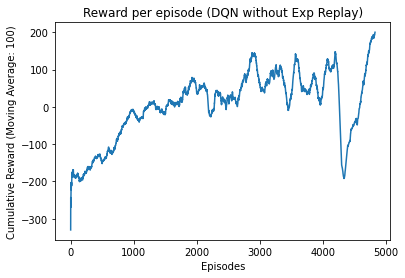

In [116]:
plt.figure()
plt.plot(range(len(avgRewards)), avgRewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward (Moving Average: 100)")
plt.title("Reward per episode (DQN without Exp Replay)")
plt.show()

## Random Policy

In [133]:
# Using a fully random policy for learning
landerRandomPolicy = DQN()
_, avgRewards = trainAgent(landerRandomPolicy, totalEpisodes = 4000, useRandomPolicy=True)

Episode : 0	 epsilon : 0.995	 Reward : -243.33
Episode : 100	 epsilon : 0.603	 Reward : -190.34
Episode : 200	 epsilon : 0.365	 Reward : -161.91
Episode : 300	 epsilon : 0.221	 Reward : -175.33
Episode : 400	 epsilon : 0.134	 Reward : -186.50
Episode : 500	 epsilon : 0.081	 Reward : -183.28
Episode : 600	 epsilon : 0.049	 Reward : -184.99
Episode : 700	 epsilon : 0.030	 Reward : -185.56
Episode : 800	 epsilon : 0.030	 Reward : -182.74
Episode : 900	 epsilon : 0.030	 Reward : -170.41
Episode : 1000	 epsilon : 0.030	 Reward : -200.54
Episode : 1100	 epsilon : 0.030	 Reward : -180.38
Episode : 1200	 epsilon : 0.030	 Reward : -184.57
Episode : 1300	 epsilon : 0.030	 Reward : -173.51
Episode : 1400	 epsilon : 0.030	 Reward : -182.60
Episode : 1500	 epsilon : 0.030	 Reward : -165.32
Episode : 1600	 epsilon : 0.030	 Reward : -190.27
Episode : 1700	 epsilon : 0.030	 Reward : -183.05
Episode : 1800	 epsilon : 0.030	 Reward : -182.38
Episode : 1900	 epsilon : 0.030	 Reward : -173.91
Episode : 20

In [ ]:
plt.figure()
plt.plot(range(len(avgRewards)), avgRewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward (Average: 100 ep)")
plt.title("Reward per episode (Random Policy)")
plt.show()

## Test the result - Render Env

In [81]:
def test(agent):
    state = env.reset()
    agent.currentNetwork.eval()
    for step in range(1000):
        env.render()
        action = agent.getBestAction(state)
        state, reward, terminal, _  = env.step(action)
        if terminal: break
        

In [88]:
test(landerAgent)

## Save Video

In [23]:
from gym import wrappers

def recordVideo(agent):
    env = wrappers.RecordVideo(gym.make("LunarLander-v2"), "./output.mp4")
    agent.currentNetwork.eval()
    state = env.reset()
    terminal = False
    while not terminal:
        action = agent.getBestAction(state)
        state, reward, terminal, _ = env.step(action)        
    env.close()

In [24]:
recordVideo(landerAgent)